In [1]:
!pip install pyaudio

In [2]:
import os
from json_tricks import load
import pyaudio
import wave
from array import array
import struct
import time
from datetime import datetime
import shutil
import numpy as np
import librosa
from pydub import AudioSegment, effects
import noisereduce as nr
import tensorflow as tf
import matplotlib.pyplot as plt


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
saved_model_path = 'D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/model.json'
saved_weights_path = 'D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/model_weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 64)           20480     
                                                                 
 dropout (Dropout)           (None, 400, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [4]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100


In [5]:
def voice_predictions():



    
    RATE = 24414
    CHUNK = 512
    RECORD_SECONDS = 7
    FORMAT = pyaudio.paInt32
    CHANNELS = 1

    # Initialize variables
    total_length = 204288 # desired frame length for all of the audio samples.
    frame_length = 2048
    hop_length = 512
    WAVE_OUTPUT_FILE = "D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/output_testing.wav"
    WAVE_OUTPUT_FILENAME_TESTING = "D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/dataset/Actor_02/03-01-01-01-01-01-02.wav"

    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

    data = array('h', np.random.randint(size = 512, low = 0, high = 500))

    print("** Analysis started")
    total_predictions = [] # A list for all predictions in the session.
    tic = time.perf_counter()


    print("* Analysis...")
    frames = []
    data = np.nan # Reset 'data' variable.

    timesteps = int(RATE / CHUNK * RECORD_SECONDS) # => 339

    # Insert frames to 'output.wav'.
    for i in range(0, timesteps):
        data = array('l', stream.read(CHUNK))
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done Analysis")

    rms_t = []
    zcr_t = []
    mfcc_t = []

    _, sr = librosa.load(path = WAVE_OUTPUT_FILENAME_TESTING, sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
    rawsound = AudioSegment.from_file(WAVE_OUTPUT_FILENAME_TESTING)
    # Normalize the audio to +5.0 dBFS.
    normalizedsound = effects.normalize(rawsound, headroom = 0)
    # Transform the normalized audio to np.array of samples.
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
    padded_x = np.pad(xt, (0, 204288-len(xt)), 'constant')
    # Noise reduction.
    final_x = nr.reduce_noise(y=padded_x,
                          sr=sr)

    # Features extraction
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

    # Filling the data lists
    rms_t.append(f1)
    zcr_t.append(f2)
    mfcc_t.append(f3)

    f_rms_t = np.asarray(rms_t).astype('float32')
    f_rms_t = np.swapaxes(f_rms_t,1,2)
    f_zcr_t = np.asarray(zcr_t).astype('float32')
    f_zcr_t = np.swapaxes(f_zcr_t,1,2)
    f_mfccs_t = np.asarray(mfcc_t).astype('float32')
    f_mfccs_t = np.swapaxes(f_mfccs_t,1,2)

    #print(file, emotionfix(name))


    X = np.concatenate((f_zcr_t, f_rms_t, f_mfccs_t), axis=2)

    predictions = model.predict(X, use_multiprocessing=True)

    y_pred_class = np.argmax(predictions)
    print("predictions : " + str(y_pred_class)+ " " +emotions.get(y_pred_class))


    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
    total_predictions.append(pred_np)
    print(pred_list)
    fig = plt.figure(figsize = (10, 2))
    plt.bar(emo_list, pred_np, color = 'darkturquoise')
    plt.ylabel("Probabilty (%)")
    plt.show()


    return predictions

** Analysis started
* Analysis...
* done Analysis
1/1 [==============================] - 0s 37ms/step
predictions : 0 neutral
[array([9.23685431e-01, 1.14215789e-02, 3.52333002e-02, 1.19822575e-02,
       1.68211220e-04, 3.17504746e-03, 4.39478550e-04, 1.38946995e-02],
      dtype=float32)]


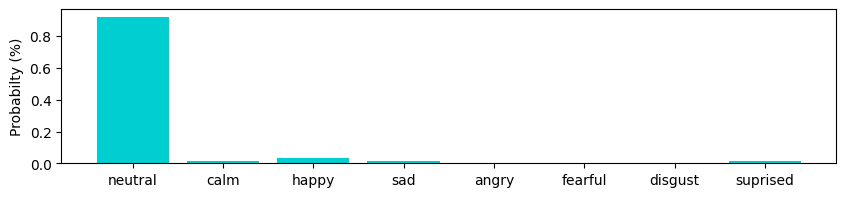

array([[9.23685431e-01, 1.14215789e-02, 3.52333002e-02, 1.19822575e-02,
        1.68211220e-04, 3.17504746e-03, 4.39478550e-04, 1.38946995e-02]],
      dtype=float32)

In [14]:
ABC = voice_predictions()
ABC